In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.cluster import KMeans
import tiktoken
import openai

In [2]:
df = pd.read_json(r"C:\Users\kaush\Desktop\fuck_you_chatPAL\pal\eval_results\gsm_complex_prompt_baseline_acc83.02.chat.jsonl",lines=True)

In [10]:
df.drop(columns=["type_error"],inplace=True)

In [4]:
GPT_MODEL = "gpt-3.5-turbo" #for tokenizer selection
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

In [5]:
df["q_tokens"] = df.input.apply(num_tokens)

In [11]:
df["g_tokens"] = df.generation.apply(num_tokens)

    We can also check here whether longer questions lead to longer generations.....

In [13]:
df["total_tokens"] = df.q_tokens + df.g_tokens

In [14]:
df

,input,target,answer,score,generation,q_tokens,g_tokens,total_tokens
0,Janet’s ducks lay 16 eggs per day. She eats th...,18,18.0,1,"Janet has 16 eggs per day, and she eats 3 for ...",64,103,167
1,A robe takes 2 bolts of blue fiber and half th...,3,3.0,1,"If a robe takes 2 bolts of blue fiber, and hal...",26,57,83
2,Josh decides to try flipping a house. He buys...,70000,120000.0,0,The increase in value of the house is 150% of ...,49,97,146
3,James decides to run 3 sprints 3 times a week....,540,540.0,1,"James runs 3 sprints per workout, and works ou...",34,76,110
4,"Every day, Wendi feeds each of her chickens th...",20,20.0,1,Wendi gives each chicken 3 cups of feed per da...,108,133,241
...,...,...,...,...,...,...,...,...
1314,John had a son James when he was 19. James is...,8,22.0,0,"If James is twice as old as Dora, and Dora wil...",58,124,182
1315,There are some oranges in a basket. Ana spends...,5,5.0,1,Ana can peel 60/3 = 20 oranges in an hour.\nJa...,58,57,115
1316,Mark's car breaks down and he needs to get a n...,230,230.0,1,"Mark gets the radiator for 80% off, so he pays...",71,88,159
1317,"Farmer Brown has 20 animals on his farm, all e...",5,5.0,1,Each chicken has 2 legs and each cow has 4 leg...,37,166,203


In [48]:
def acc_vs_token_hist_version(df,bins=5):
    # BINS = [0, 200, 400, 600, 800, 1000]
    total_tokens = df["total_tokens"].values.tolist()
    all_counts, all_token_bins = np.histogram(total_tokens, bins=bins)
    # plt.hist(all_questions, bins=all_question_bins)
    #getting the dsitrubtion of the question lengths for correct answers
    correct_answer = df[df["score"] == 1]
    token_len_correct_answer = [t for t in correct_answer.total_tokens]
    correct_counts = np.histogram(token_len_correct_answer, bins=all_token_bins)[0]
    #getting the dsitrubtion of the question lengths for wrong answers
    wrong_answer = df[df["score"] == 0]
    token_len_wrong_answer = [t for t in wrong_answer.total_tokens]
    wrong_counts = np.histogram(token_len_wrong_answer, bins=all_token_bins)[0]
    pct_correct = correct_counts / all_counts
    #replace nan with 0
    pct_correct = np.nan_to_num(pct_correct)
    pct_wrong = wrong_counts / all_counts
    pct_wrong = np.nan_to_num(pct_wrong)
    plt.figure(figsize=(12,8))
    plt.title("Percentage Error vs. Context Length (binned)")
    plt.hist(total_tokens, bins=all_token_bins, alpha=0.2, label="all")
    plt.hist(token_len_correct_answer, bins=all_token_bins, alpha=0.4, label="correct")
    plt.hist(token_len_wrong_answer, bins=all_token_bins, alpha=0.6, label="wrong")
    plt.legend()
    # add a line after x-axis
    # wherever both are zero, there are no questions to count
    print(f"Number of records in bin: {all_counts}")
    print(f"% correct in each bins:   {pct_correct}")
    print(f"% wrong in each bins:     {pct_wrong}")

Number of records in bin: [652 568  86  11   2]
% correct in each bins:   [0.9202454  0.77640845 0.58139535 0.36363636 0.        ]
% wrong in each bins:     [0.0797546  0.22359155 0.41860465 0.63636364 1.        ]


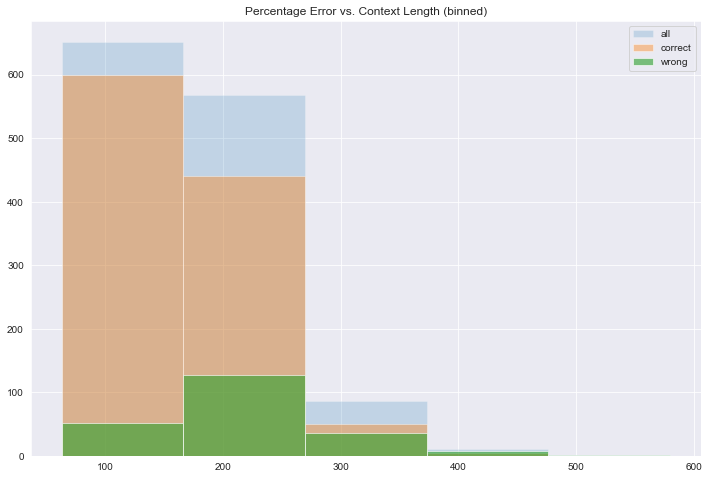

In [49]:
acc_vs_token_hist_version(df,bins=5)

In [50]:
def acc_vs_token_line_version(results,bins=5):
    # BINS = [0, 200, 400, 600, 800, 1000]
    total_tokens = df["total_tokens"].values.tolist()
    all_counts, all_token_bins = np.histogram(total_tokens, bins=bins)
    # plt.hist(all_questions, bins=all_question_bins)
    #getting the dsitrubtion of the question lengths for correct answers
    correct_answer = df[df["score"] == 1]
    token_len_correct_answer = [t for t in correct_answer.total_tokens]
    correct_counts = np.histogram(token_len_correct_answer, bins=all_token_bins)[0]
    #getting the dsitrubtion of the question lengths for wrong answers
    wrong_answer = df[df["score"] == 0]
    token_len_wrong_answer = [t for t in wrong_answer.total_tokens]
    wrong_counts = np.histogram(token_len_wrong_answer, bins=all_token_bins)[0]
    pct_correct = correct_counts / all_counts
    #replace nan with 0
    pct_correct = np.nan_to_num(pct_correct)
    pct_wrong = wrong_counts / all_counts
    pct_wrong = np.nan_to_num(pct_wrong)
    plt.figure(figsize=(12,8))
    plt.title("Percentage Error vs. Question Length (binned)")
    plt.plot(pct_correct*100, label="correct")
    plt.plot(pct_wrong*100, label="wrong")
    plt.legend()
    print(f"Number of records in bin: {all_counts}")
    print(f"% correct in each bins:   {pct_correct}")
    print(f"% wrong in each bins:     {pct_wrong}")
    # add a line after x-axis
    # wherever both are zero, there are no questions to count

Number of records in bin: [274 573 335  94  34   7   1   1]
% correct in each bins:   [0.93430657 0.89179756 0.74925373 0.61702128 0.5        0.28571429
 0.         0.        ]
% wrong in each bins:     [0.06569343 0.10820244 0.25074627 0.38297872 0.5        0.71428571
 1.         1.        ]


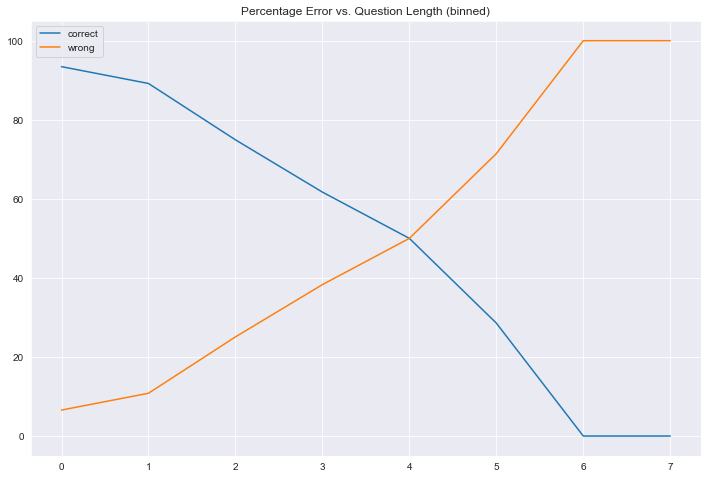

In [51]:
acc_vs_token_line_version(df,bins=8)

### Let's make a general variable version of these functions:

In [56]:
def acc_vs_token_hist_version(df,column,bins=5):
    # BINS = [0, 200, 400, 600, 800, 1000]
    all_column_values = df[column].values.tolist()
    all_counts, all_bins = np.histogram(all_column_values, bins=bins)
    # plt.hist(all_questions, bins=all_question_bins)
    #getting the dsitrubtion of the question lengths for correct answers
    correct_answer = df[df["score"] == 1]
    column_correct_answer = [t for t in correct_answer[column]]
    correct_counts = np.histogram(column_correct_answer, bins=all_bins)[0]
    #getting the dsitrubtion of the question lengths for wrong answers
    wrong_answer = df[df["score"] == 0]
    column_wrong_answer = [t for t in wrong_answer[column]]
    wrong_counts = np.histogram(column_wrong_answer, bins=all_bins)[0]
    pct_correct = correct_counts / all_counts
    #replace nan with 0
    pct_correct = np.nan_to_num(pct_correct)
    pct_wrong = wrong_counts / all_counts
    pct_wrong = np.nan_to_num(pct_wrong)
    plt.figure(figsize=(12,8))
    plt.title(f"Percentage Error vs. {column} (binned)")
    plt.hist(all_column_values, bins=all_bins, alpha=0.2, label="all")
    plt.hist(column_correct_answer, bins=all_bins, alpha=0.4, label="correct")
    plt.hist(column_wrong_answer, bins=all_bins, alpha=0.6, label="wrong")
    plt.legend()
    # add a line after x-axis
    # wherever both are zero, there are no questions to count
    print(f"Number of records in bin: {all_counts}")
    print(f"% correct in each bins:   {pct_correct}")
    print(f"% wrong in each bins:     {pct_wrong}")

In [57]:
def acc_vs_token_line_version(df,column,bins=5):
    # BINS = [0, 200, 400, 600, 800, 1000]
    all_column_values = df[column].values.tolist()
    all_counts, all_bins = np.histogram(all_column_values, bins=bins)
    # plt.hist(all_questions, bins=all_question_bins)
    #getting the dsitrubtion of the question lengths for correct answers
    correct_answer = df[df["score"] == 1]
    column_correct_answer = [t for t in correct_answer[column]]
    correct_counts = np.histogram(column_correct_answer, bins=all_bins)[0]
    #getting the dsitrubtion of the question lengths for wrong answers
    wrong_answer = df[df["score"] == 0]
    column_wrong_answer = [t for t in wrong_answer[column]]
    wrong_counts = np.histogram(column_wrong_answer, bins=all_bins)[0]
    pct_correct = correct_counts / all_counts
    #replace nan with 0
    pct_correct = np.nan_to_num(pct_correct)
    pct_wrong = wrong_counts / all_counts
    pct_wrong = np.nan_to_num(pct_wrong)
    plt.figure(figsize=(12,8))
    plt.title(f"Percentage Error vs. {column} (binned)")
    plt.plot(pct_correct*100, label="correct")
    plt.plot(pct_wrong*100, label="wrong")
    plt.legend()
    print(f"Number of records in bin: {all_counts}")
    print(f"% correct in each bins:   {pct_correct}")
    print(f"% wrong in each bins:     {pct_wrong}")
    # add a line after x-axis
    # wherever both are zero, there are no questions to count

Number of records in bin: [274 573 335  94  34   7   1   1]
% correct in each bins:   [0.93430657 0.89179756 0.74925373 0.61702128 0.5        0.28571429
 0.         0.        ]
% wrong in each bins:     [0.06569343 0.10820244 0.25074627 0.38297872 0.5        0.71428571
 1.         1.        ]


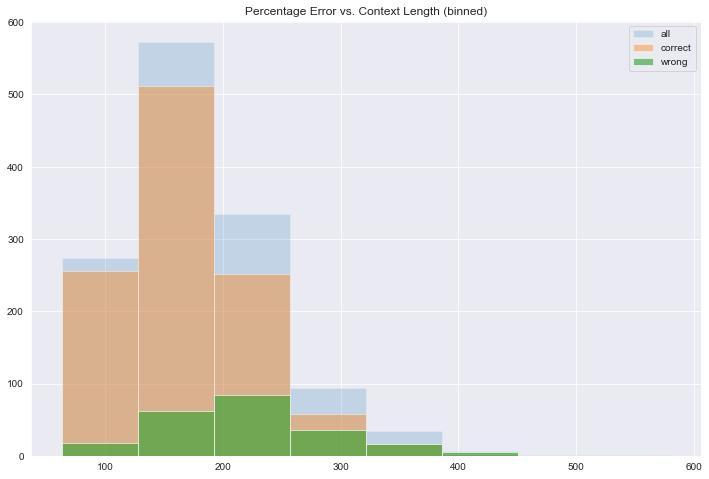

In [60]:
acc_vs_token_hist_version(df,"total_tokens",bins=8)

Number of records in bin: [274 573 335  94  34   7   1   1]
% correct in each bins:   [0.93430657 0.89179756 0.74925373 0.61702128 0.5        0.28571429
 0.         0.        ]
% wrong in each bins:     [0.06569343 0.10820244 0.25074627 0.38297872 0.5        0.71428571
 1.         1.        ]


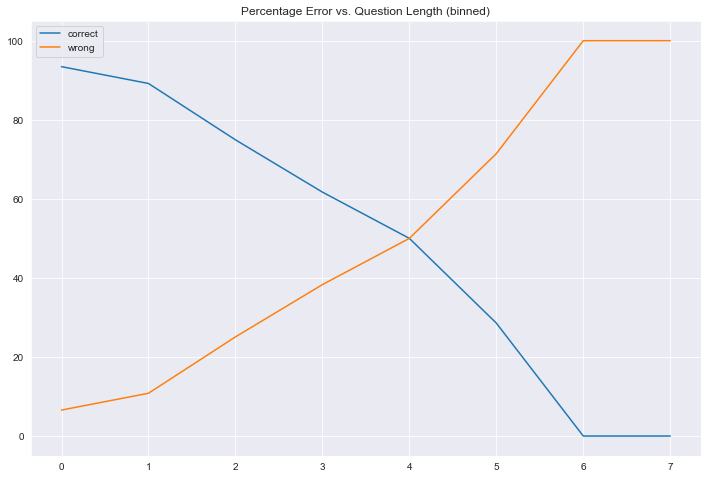

In [61]:
acc_vs_token_line_version(df,"total_tokens",bins=8)

C:\Users\kaush\AppData\Local\Temp\ipykernel_31436\3335795504.py:14: RuntimeWarning: invalid value encountered in true_divide
  pct_correct = correct_counts / all_counts
C:\Users\kaush\AppData\Local\Temp\ipykernel_31436\3335795504.py:17: RuntimeWarning: invalid value encountered in true_divide
  pct_wrong = wrong_counts / all_counts


Number of records in bin: [503 583 168  51  11   2   0   1]
% correct in each bins:   [0.92842942 0.83533448 0.6547619  0.49019608 0.45454545 0.5
 0.         0.        ]
% wrong in each bins:     [0.07157058 0.16466552 0.3452381  0.50980392 0.54545455 0.5
 0.         1.        ]


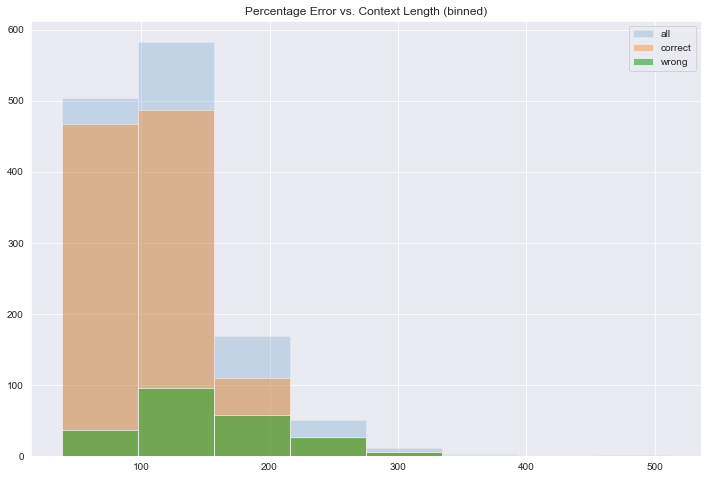

In [62]:
acc_vs_token_hist_version(df,"g_tokens",bins=8)

C:\Users\kaush\AppData\Local\Temp\ipykernel_31436\3364848601.py:14: RuntimeWarning: invalid value encountered in true_divide
  pct_correct = correct_counts / all_counts
C:\Users\kaush\AppData\Local\Temp\ipykernel_31436\3364848601.py:17: RuntimeWarning: invalid value encountered in true_divide
  pct_wrong = wrong_counts / all_counts


Number of records in bin: [503 583 168  51  11   2   0   1]
% correct in each bins:   [0.92842942 0.83533448 0.6547619  0.49019608 0.45454545 0.5
 0.         0.        ]
% wrong in each bins:     [0.07157058 0.16466552 0.3452381  0.50980392 0.54545455 0.5
 0.         1.        ]


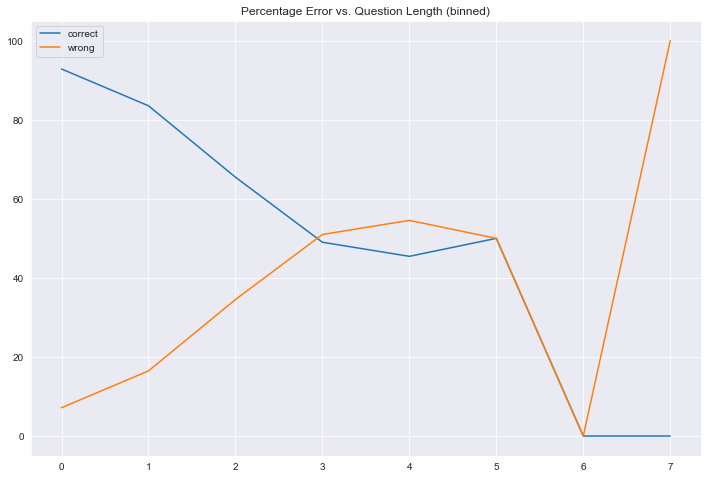

In [63]:
acc_vs_token_line_version(df,"g_tokens",bins=8)

In [90]:
def col_vs_col_plot(df,col1, col2):
    #only numerical columns
    f, ax = plt.subplots(figsize=(12, 8))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x=col1, y=col2,
                    hue="score",
                    data=df, ax=ax)

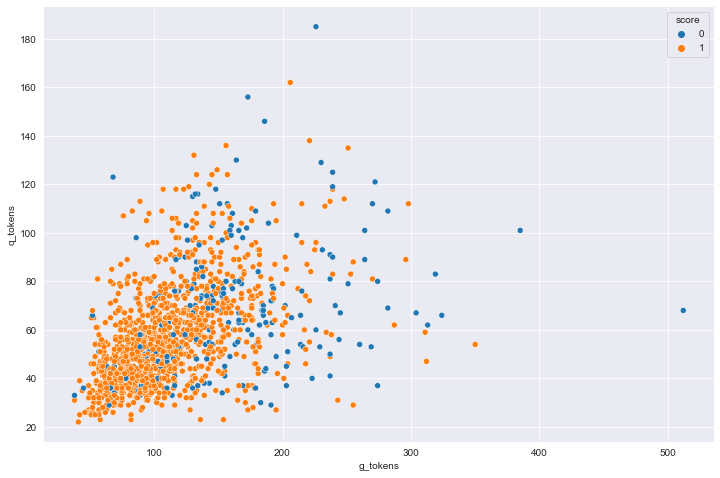

In [91]:
col_vs_col_plot(df,"g_tokens", "q_tokens")

In [96]:
def col_vs_col_plot_score0(df,col1, col2):
    #only numerical columns
    sub_df = df[df["score"] == 0]
    f, ax = plt.subplots(figsize=(12, 8))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x=col1, y=col2,
                    hue="score",
                    data=sub_df, ax=ax)

In [97]:
def col_vs_col_plot_score1(df,col1, col2):
    #only numerical columns
    sub_df = df[df["score"] == 1]
    f, ax = plt.subplots(figsize=(12, 8))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(x=col1, y=col2,
                    hue="score",
                    data=sub_df, ax=ax)

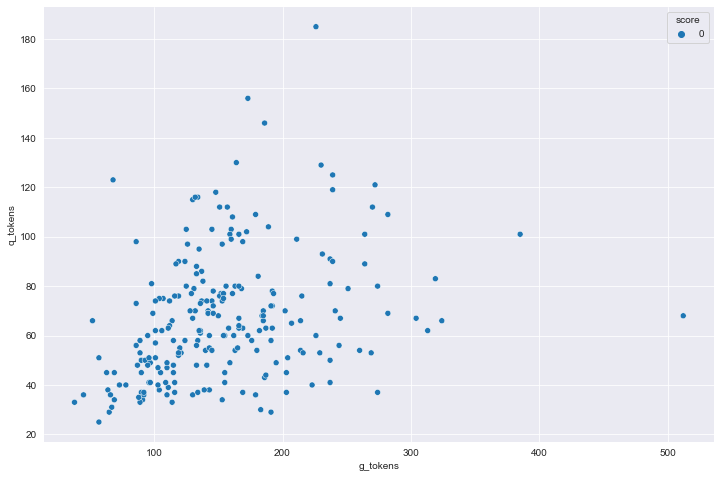

In [98]:
col_vs_col_plot_score0(df,"g_tokens", "q_tokens")

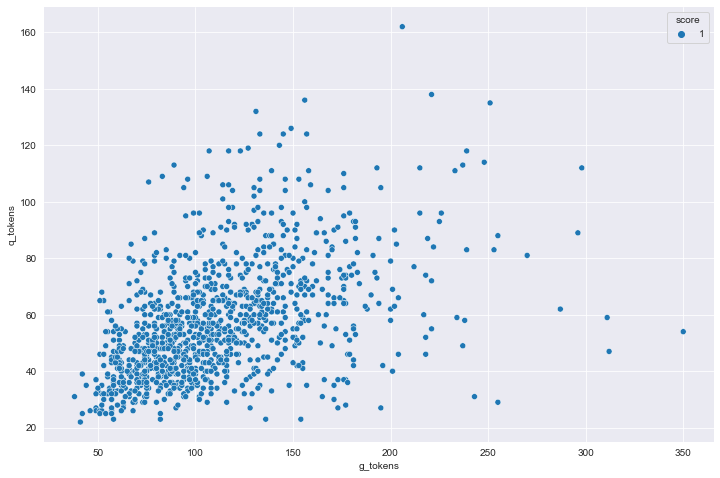

In [99]:
col_vs_col_plot_score1(df,"g_tokens", "q_tokens")